# Сбор данных

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ilia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Чтение исходных данных из файла

In [2]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()


,uid,cat
0,40585382,1
1,30005269,0
2,3314758074,0
3,14311688,0
4,110457801,0


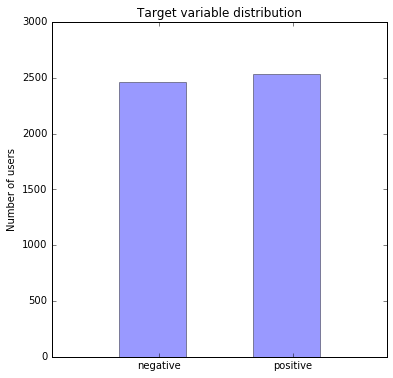

In [3]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cat"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

In [4]:
CONSUMER_KEY = "---"
CONSUMER_SECRET = "---"

ACCESS_TOKEN_KEY = "---"
ACCESS_TOKEN_SECRET =  "---"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

In [5]:
GEO_USER_NAME = "denilv"
processed_locs = {}
def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    """
    url1 = 'http://api.geonames.org/searchJSON?q="'
    url2 = '"&maxRows=10&username=' + GEO_USER_NAME
    for i in location:
        if not (i.isalnum() or i.isspace()) : location=location.replace(i, ' ')
    url = url1 + location + url2
    if location in processed_locs:
        return processed_locs[location]
    else :
        try:
            r = requests.get(url)
            j = json.loads(r.content)
            if (j['totalResultsCount'] != 0):
                lng = float(j['geonames'][0]['lng'])
                lat = float(j['geonames'][0]['lat'])
                name  = j['geonames'][0]['countryName']
                processed_locs[location] = (lat, lng, name)
                return (lat, lng, name)
            else:
                return (NaN, NaN, NaN)
        except Exception as e:
            #print r
            #print e
            return (NaN, NaN, NaN)


# Data frame

In [57]:
import sys
df_full = None

In [ ]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


def get_user_records(df):
    max_users_per_request = 100
    uids = []
    users = []
    for i in df_users.uid:
        uids.append(i)
    #sys.stdout.write("\r%d%%" % i)
    
    for i in range(0, len(uids), max_users_per_request):
        sys.stdout.write('\rTwitter %.2f %%' % (float(i)/len(uids)*100))
        sys.stdout.flush()
        users+=api.UsersLookup(uids[i:i+max_users_per_request])
        #if len(users)>1000: break
        #clear_output()
    records = []
    z=0
    for i in users:
        #print float(i)/len(users)
        z+=1
        sys.stdout.write('\rGEO %.2f %%' % (float(z)/len(users)*100))
        sys.stdout.flush()
        records.append(twitter_user_to_dataframe_record(i))
        #clear_output()
    return records

# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users)

        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Twitter 53.64 %

## Exploratory Data Analysis

In [8]:
grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))

114
114


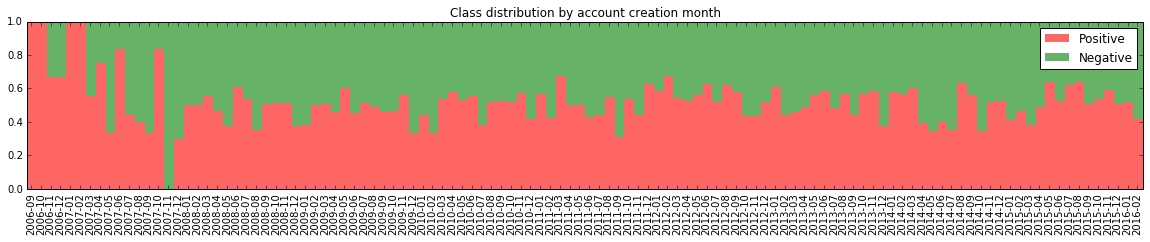

In [118]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    month_pos = 0
    month_neg = 0
    pos = []
    neg = []
    dts = []

    
    count_pos, count_neg = np.array([]), np.array([])#np.zeros(len(grouped)), np.zeros(len(grouped))
    for i in grouped.groups.items():
        for j in i[1]:
            if df_full.cat[j]==0: month_pos+=1
            if df_full.cat[j]==1: month_neg+=1
        count_pos = np.append(count_pos, month_pos)
        count_neg = np.append(count_neg, month_neg)
        month_pos = 0
        month_neg = 0
        dts.append(i[0])
    print len(count_pos)
    print len(grouped)
    return  count_neg, count_pos, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

In [73]:
df_full = df_full[pd.notnull(df_full['name'])]
df_full["lat"].fillna(value = 0, inplace = True)
df_full["lon"].fillna(value = 0, inplace = True)


In [114]:
marker_sizes = {}
for i, j, k in zip(df_full.lat.values, df_full.lon.values, df_full.cat.values):
    #if marker_sizes.has_key((i,j)): marker_sizes[(i,j)] += 1 else: marker_sizes[(i,j)] = 1
    if i!=0 and j!=0:
        marker_sizes[(i,j,k)] = marker_sizes.get((i,j,k), 0) + 1

In [128]:
def get_marker_size(size):
    if (size > 200): return 40
    if (size > 100): return 20
    if (size > 50): return 15
    if (size > 10): return 10
    return 3

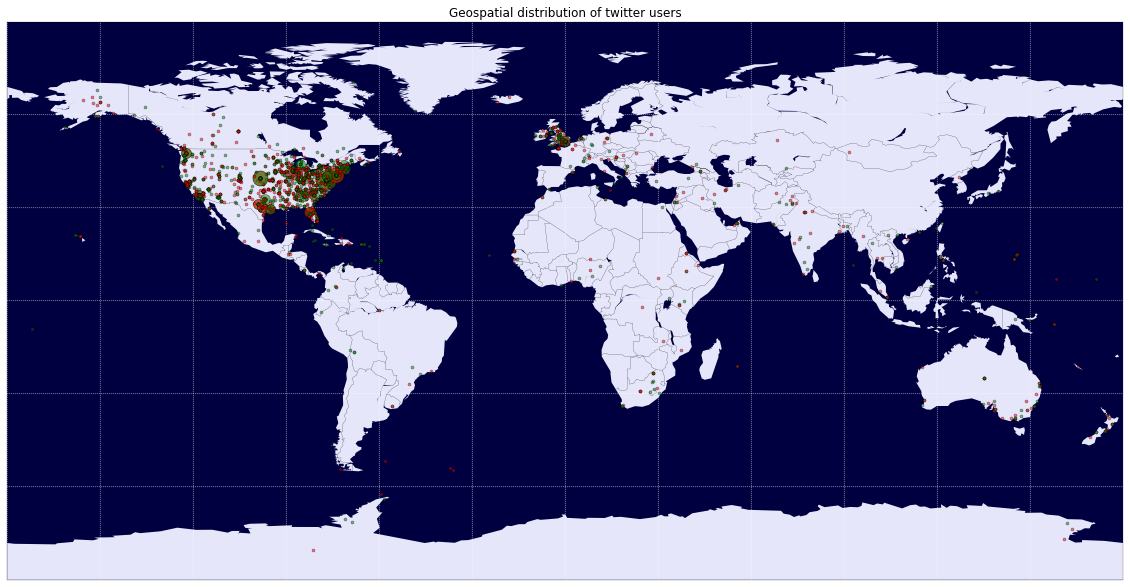

In [129]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    for x, size in marker_sizes.iteritems():
        if (x[2]==1): clr = 'green'
        if (x[2]==0): clr = 'red'    
        m.plot(x[1] ,x[0], 'o', color=clr, markersize=get_marker_size(size), alpha = 0.5)
    #pl.scatter(x,y,3,marker='o',color='k')
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

In [70]:
OUT_FILE_PATH = "hw1_out var4.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out var4.csv


,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76000,-98.50000,United States,2009-05,7610,4283,50614,787,416
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1919,1241,7160,127,97
2,3314758074,0,Campaign Trump,Campaign_Trump,#AlwaysTrump for President. Indp Local & Inter...,False,"North Carolina, USA",34.00071,-81.03481,United States,2015-08,22747,12402,1952,7568,187
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,40.71427,-74.00597,United States,2008-04,1765,1298,7372,176,110
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,0.00000,0.00000,NaN,2010-02,1482,1189,37208,3322,76
